In [1]:
library("gstat")
library("geosphere")
library("sp")
library("maptools")
library("ggplot2")
library(INLA)
library(spdep)
# library(rSPDE)

Please note that 'maptools' will be retired during October 2023,
plan transition at your earliest convenience (see
https://r-spatial.org/r/2023/05/15/evolution4.html and earlier blogs
for guidance);some functionality will be moved to 'sp'.
 Checking rgeos availability: TRUE


Attaching package: ‘maptools’


The following object is masked from ‘package:sp’:

    sp2Mondrian


Warning message:
“package ‘INLA’ was built under R version 4.4.0”
Loading required package: Matrix

This is INLA_24.05.10 built 2024-05-10 19:59:04 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - List available models/likelihoods/etc with inla.list.models()
 - Use inla.doc(<NAME>) to access documentation

Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: sf

Linking to GEOS 3.12.0, GDAL 3.7.2, PROJ 9.3.0; sf_use_s2() is TR

In [2]:
data(meuse)
summary(meuse)

x <- seq(from = 0, to = 1, length.out = 101)
plot(x, matern.covariance(abs(x - 0.5), kappa = 10, nu = 1 / 5, sigma = 1),
  type = "l", ylab = "C(h)", xlab = "h"
)

       x                y             cadmium           copper      
 Min.   :178605   Min.   :329714   Min.   : 0.200   Min.   : 14.00  
 1st Qu.:179371   1st Qu.:330762   1st Qu.: 0.800   1st Qu.: 23.00  
 Median :179991   Median :331633   Median : 2.100   Median : 31.00  
 Mean   :180005   Mean   :331635   Mean   : 3.246   Mean   : 40.32  
 3rd Qu.:180630   3rd Qu.:332463   3rd Qu.: 3.850   3rd Qu.: 49.50  
 Max.   :181390   Max.   :333611   Max.   :18.100   Max.   :128.00  
                                                                    
      lead            zinc             elev             dist        
 Min.   : 37.0   Min.   : 113.0   Min.   : 5.180   Min.   :0.00000  
 1st Qu.: 72.5   1st Qu.: 198.0   1st Qu.: 7.546   1st Qu.:0.07569  
 Median :123.0   Median : 326.0   Median : 8.180   Median :0.21184  
 Mean   :153.4   Mean   : 469.7   Mean   : 8.165   Mean   :0.24002  
 3rd Qu.:207.0   3rd Qu.: 674.5   3rd Qu.: 8.955   3rd Qu.:0.36407  
 Max.   :654.0   Max.   :1839.0   

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'y' in selecting a method for function 'plot': could not find function "matern.covariance"


Warning message in CPL_crs_from_input(x):
“GDAL Message 1: +init=epsg:XXXX syntax is deprecated. It might return a CRS with a non-EPSG compliant axis order.”


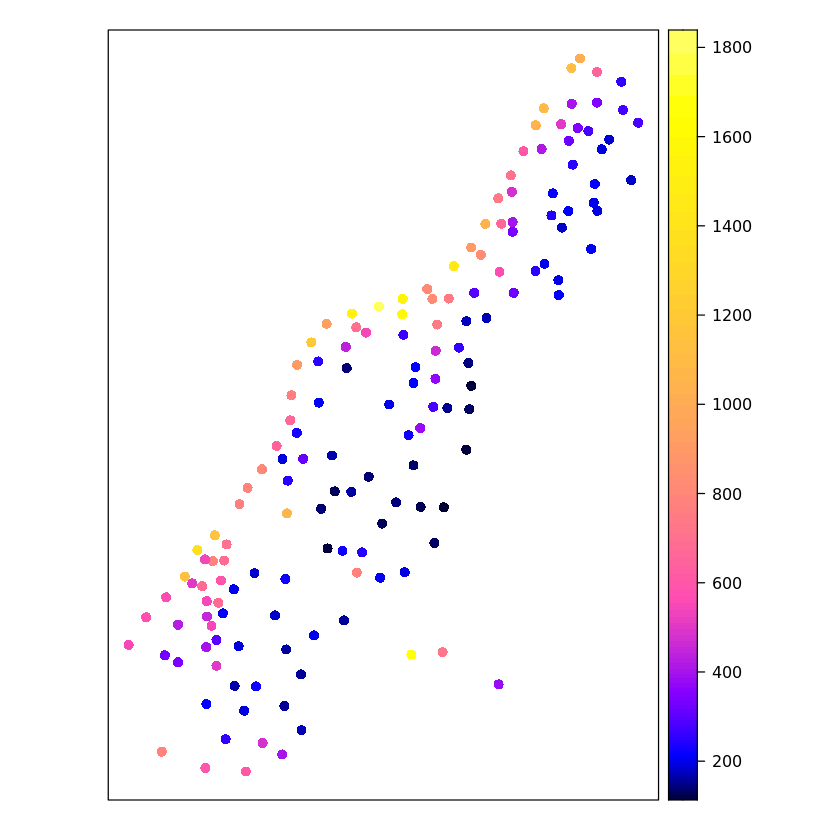

In [3]:
coordinates(meuse) <- ~x+y
proj4string(meuse) <- CRS("+init=epsg:28992")
spplot(meuse, "zinc", do.log = T, colorkey = TRUE)

In [2]:
## -----------------------------------------------------------------------------
# #Code from gstat
# data(meuse.grid)
# coordinates(meuse.grid) = ~x+y
# proj4string(meuse.grid) <- CRS("+init=epsg:28992")
# gridded(meuse.grid) = TRUE

# # Variogram and fit variogram
# vgm <- variogram(log(zinc) ~ dist, meuse)
# fit.vgm <- fit.variogram(vgm, vgm("Sph"))
# plot(vgm)
# plot(variogram(log(zinc)~1,meuse),type="l")

DATA <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/NFI_CCI_GEDIheights.csv") #Read the saved data
coordinates(DATA) = ~X+X.1
proj4string(DATA) <- CRS("+init=epsg:6933")
DATA <- st_as_sf(DATA) %>% st_transform(crs = 4326)
DATA$lon = st_coordinates(DATA)[,1]
DATA$lat = st_coordinates(DATA)[,2]

temp <- st_drop_geometry(DATA[,c("cci.plot", "agbd.plot")])
coeffs <- cor(temp, temp)
coeffs <- as.vector(coeffs[lower.tri(coeffs, diag = FALSE)])
coeffs
dist <- geosphere::distm(as.matrix(st_drop_geometry(DATA[5:6])))
dist <- as.vector(dist[lower.tri(dist, diag = FALSE)])

# corr_dist <- data.frame(coeffs=coeffs, dist=dist)

ggplot(data=corr_dist, aes(x=dist, y=coeffs)) + geom_point() + theme_minimal()

Warning message in CPL_crs_from_input(x):
“GDAL Message 1: +init=epsg:XXXX syntax is deprecated. It might return a CRS with a non-EPSG compliant axis order.”


[1] 0.5248506

ERROR: Error in ggplot(data = corr_dist, aes(x = dist, y = coeffs)): object 'corr_dist' not found


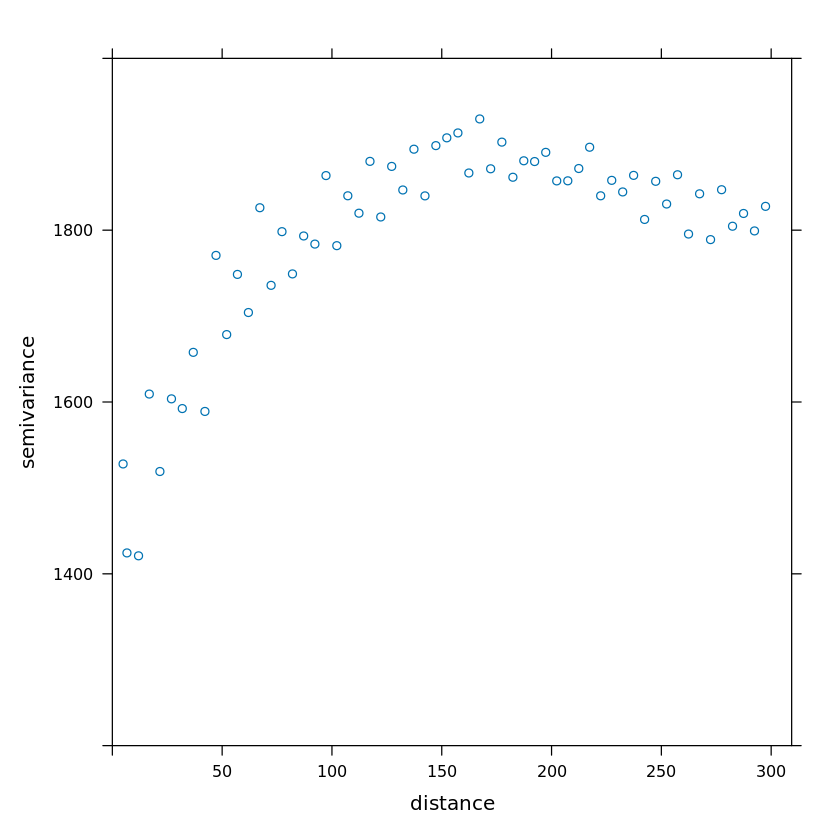

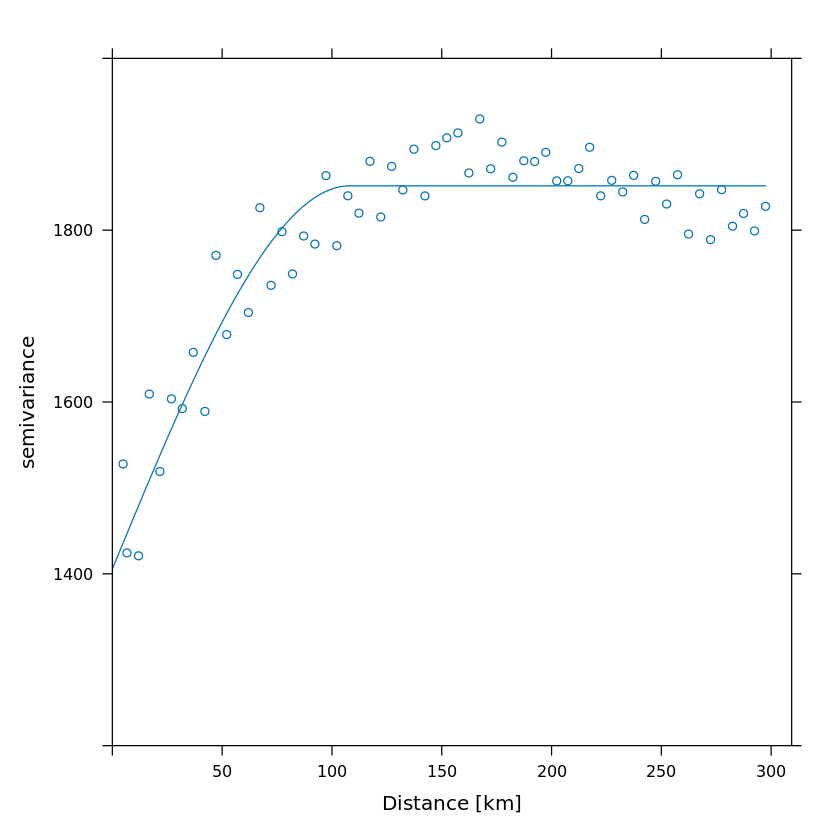

In [36]:
DATA <- read.csv("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/NFI_CCI_GEDIheights.csv") #Read the saved data
coordinates(DATA) = ~X+X.1
proj4string(DATA) <- CRS("+init=epsg:6933")
DATA <- st_as_sf(DATA) %>% st_transform(crs = 4326)
vgm <- variogram(agbd.plot ~ 1, DATA, width=5, cutoff=300)
plot(vgm,ylim=c(1200,2000))
fit.vgm <- fit.variogram(vgm, vgm("Sph"))
plot(vgm,model=fit.vgm,ylim=c(1200,2000), xlab = "Distance [km]")

# # following https://stats.oarc.ucla.edu/r/faq/how-can-i-calculate-morans-i-in-r/
# houseDF.dists <- as.matrix(dist(cbind(DATA$X, DATA$X.1)))
# houseDF.dists.inv <- 1/houseDF.dists
# houseDF.dists.inv[is.infinite(houseDF.dists.inv)] <- 0
# diag(houseDF.dists.inv) <- 0
# Moran.I(DATA$agbd.plot, houseDF.dists.inv)

In [26]:
# Kriging
krg <- krige(log(zinc) ~ dist, meuse, meuse.grid, model = fit.vgm)

[using universal kriging]


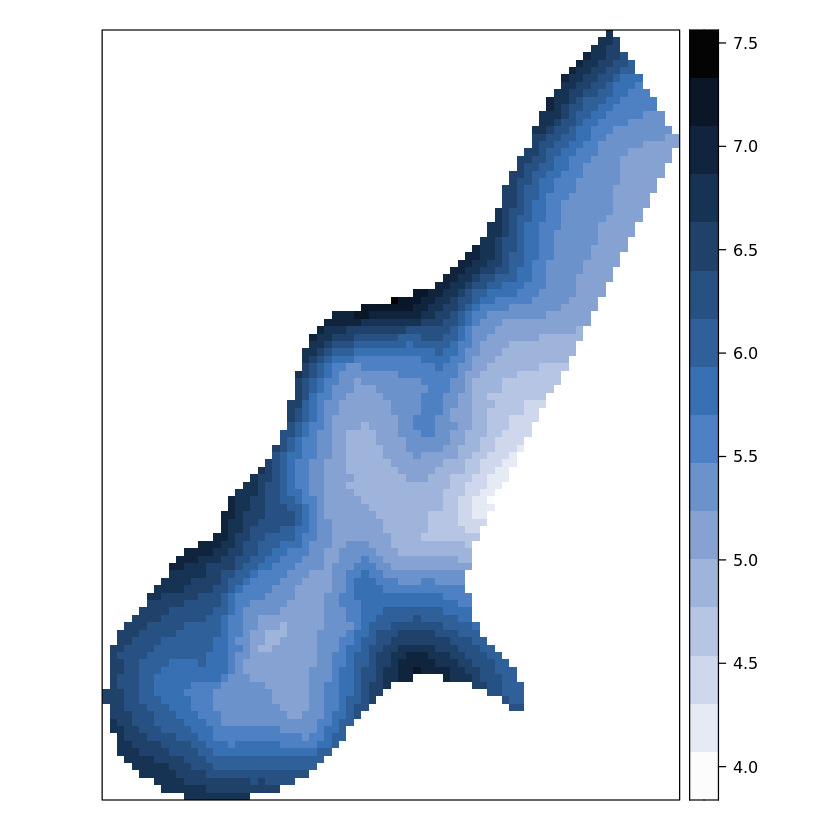

In [27]:
#Add estimates to meuse.grid
meuse.grid$zinc.krg <- krg$var1.pred
meuse.grid$zinc.krg.sd <- sqrt(krg$var1.var)

## ----fig = TRUE, echo = FALSE, label = "ukrg-zinc", fig.cap = "Concentration of zinc (log-scale) estimated with universal kriging for the `meuse` dataset."----
spplot(meuse.grid, c("zinc.krg"), col.regions = hcl.colors(16, "Oslo"))

rgeos version: 0.6-4, (SVN revision 699)
 GEOS runtime version: 3.12.0-CAPI-1.18.0 
 Please note that rgeos will be retired during October 2023,
plan transition to sf or terra functions using GEOS at your earliest convenience.
See https://r-spatial.org/r/2023/05/15/evolution4.html for details.
 GEOS using OverlayNG
 Linking to sp version: 2.0-0 
 Polygon checking: TRUE 


Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“"with" is not a graphical parameter”


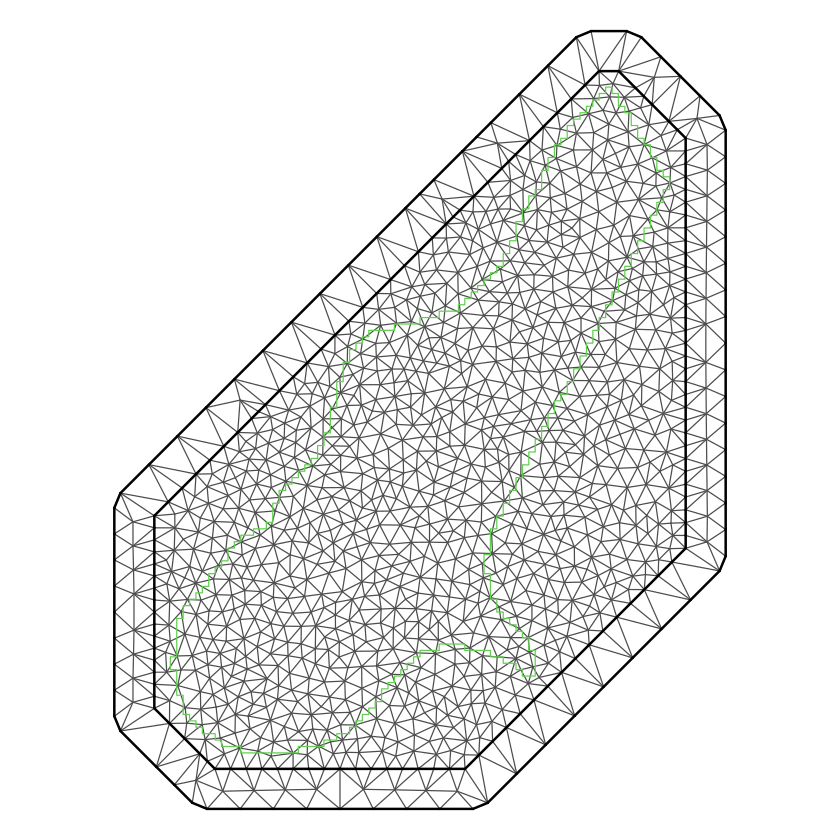

In [28]:
meuse.bdy <- unionSpatialPolygons(
  as(meuse.grid, "SpatialPolygons"), rep (1, length(meuse.grid))
)
#Define mesh
pts <- meuse.bdy@polygons[[1]]@Polygons[[1]]@coords
mesh <- inla.mesh.2d(loc.domain = pts, max.edge = c(150, 500),
  offset = c(100, 250) )
par(mar = c(0, 0, 0, 0))
plot(mesh, asp = 1, main = "")
lines(pts, col = 3, with = 2)

In [29]:
#Create SPDE
meuse.spde <- inla.spde2.matern(mesh = mesh, alpha = 2)
A.meuse <- inla.spde.make.A(mesh = mesh, loc = coordinates(meuse))
s.index <- inla.spde.make.index(name = "spatial.field",n.spde = meuse.spde$n.spde)

In [30]:
#Create data structure
meuse.stack <- inla.stack(data  = list(zinc = meuse$zinc),
  A = list(A.meuse, 1),
  effects = list(c(s.index, list(Intercept = 1)),
    list(dist = meuse$dist)),
  tag = "meuse.data")

In [31]:
#Create data structure for prediction
A.pred <- inla.spde.make.A(mesh = mesh, loc = coordinates(meuse.grid))
meuse.stack.pred <- inla.stack(data = list(zinc = NA),
  A = list(A.pred, 1),
  effects = list(c(s.index, list (Intercept = 1)),
    list(dist = meuse.grid$dist)),
  tag = "meuse.pred")
#Join stack
join.stack <- inla.stack(meuse.stack, meuse.stack.pred)

In [32]:
#Fit model
form <- log(zinc) ~ -1 + Intercept + dist + f(spatial.field, model = spde)

In [33]:
m1 <- inla(form, data = inla.stack.data(join.stack, spde = meuse.spde),
  family = "gaussian",
  control.predictor = list(A = inla.stack.A(join.stack), compute = TRUE),
  control.compute = list(cpo = TRUE, dic = TRUE))

#Summary of results
summary(m1)


Call:
   c("inla.core(formula = formula, family = family, contrasts = contrasts, 
   ", " data = data, quantiles = quantiles, E = E, offset = offset, ", " 
   scale = scale, weights = weights, Ntrials = Ntrials, strata = strata, 
   ", " lp.scale = lp.scale, link.covariates = link.covariates, verbose = 
   verbose, ", " lincomb = lincomb, selection = selection, control.compute 
   = control.compute, ", " control.predictor = control.predictor, 
   control.family = control.family, ", " control.inla = control.inla, 
   control.fixed = control.fixed, ", " control.mode = control.mode, 
   control.expert = control.expert, ", " control.hazard = control.hazard, 
   control.lincomb = control.lincomb, ", " control.update = 
   control.update, control.lp.scale = control.lp.scale, ", " 
   control.pardiso = control.pardiso, only.hyperparam = only.hyperparam, 
   ", " inla.call = inla.call, inla.arg = inla.arg, num.threads = 
   num.threads, ", " keep = keep, working.directory = working.directory,

In [28]:
#Get predicted data on grid
index.pred <- inla.stack.index(join.stack, "meuse.pred")$data

meuse.grid$zinc.spde <- m1$summary.fitted.values[index.pred, "mean"]
meuse.grid$zinc.spde.sd <- m1$summary.fitted.values[index.pred, "sd"]

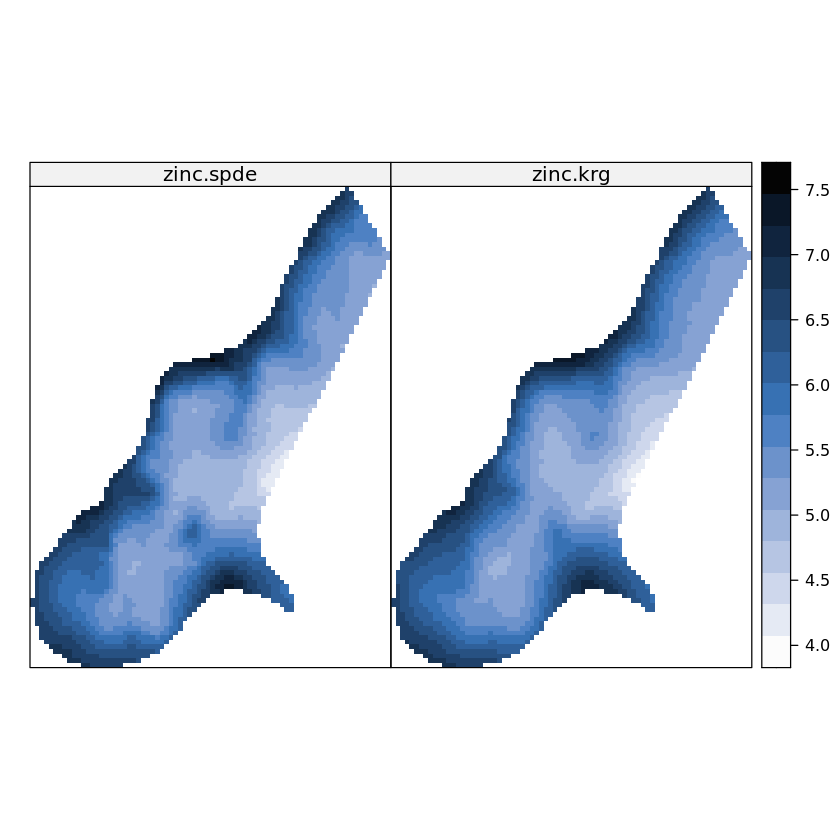

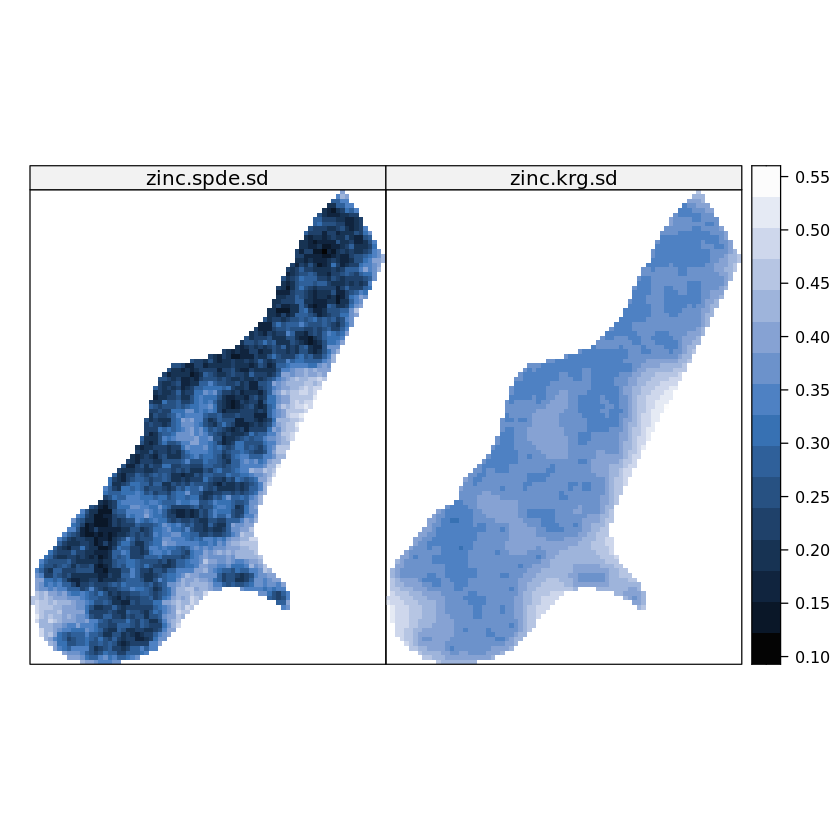

In [33]:
## ----fig = TRUE, echo = FALSE, label = "meuse-pred", fig.cap = "Posterior means of log-concentration of zinc."----
#Display perdicted data on grid
spplot(meuse.grid, c("zinc.spde", "zinc.krg"), col.regions = hcl.colors(16, "Oslo"))


## ----fig = TRUE, echo = FALSE, label = "meuse-pred-sd", fig.cap = "Posterior prediction standard deviations of log-concentration of zinc."----
#Display perdicted data on grid
spplot(meuse.grid, c("zinc.spde.sd", "zinc.krg.sd"),
  col.regions = rev(hcl.colors(16, "Oslo")))


In [32]:
## -----------------------------------------------------------------------------
#Compute statistics in terms or range and variance
spde.est <- inla.spde2.result(inla = m1, name = "spatial.field",spde = meuse.spde, do.transf = TRUE)

#Kappa
#inla.zmarginal(spde.est$marginals.kappa[[1]])
#Variance
inla.zmarginal(spde.est$marginals.variance.nominal[[1]])
#Range
inla.zmarginal(spde.est$marginals.range.nominal[[1]])


## -----------------------------------------------------------------------------
#Summary stats; nugget is a 'random' effect with a variance
fit.vgm


## -----------------------------------------------------------------------------
#Precision of nugget term (similar to precision of error term)
1 / fit.vgm$psill[1]

Mean            0.251775 
Stdev           0.0602879 
Quantile  0.025 0.154056 
Quantile  0.25  0.208471 
Quantile  0.5   0.244611 
Quantile  0.75  0.287198 
Quantile  0.975 0.389739 
Mean            415.886 
Stdev           132.069 
Quantile  0.025 212.497 
Quantile  0.25  320.55 
Quantile  0.5   397.091 
Quantile  0.75  490.086 
Quantile  0.975 726.852 


,model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Nug,0.07642515,0.0000,0.0,0,0,0,1,1
2,Sph,0.20529402,728.6969,0.5,0,0,0,1,1


[1] 13.0847